<a href="https://colab.research.google.com/github/pa-shk/movie-review-classification/blob/master/reviews_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up the environment

In [2]:
import glob
import re

import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

In [3]:
SEED = 42

# Dataset preparation

In [4]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

--2023-07-08 15:30:02--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  21.3MB/s    in 6.2s    

2023-07-08 15:30:08 (12.8 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [5]:
train_files = [*glob.glob("**/aclImdb/train/neg/*.txt", recursive=True),
               *glob.glob("**/aclImdb/train/pos/*.txt", recursive=True)]

train_rating = [int(re.findall("\d+", i)[-1]) for i in train_files]
train_sentiment = [int(i < 5) for i in train_rating]

test_files = [*glob.glob("**/aclImdb/test/neg/*.txt", recursive=True),
              *glob.glob("**/aclImdb/test/pos/*.txt", recursive=True)]

test_rating = [int(re.findall("\d+", i)[-1]) for i in test_files]
test_sentiment = [int(i < 5) for i in test_rating]

In [6]:
len(train_files)

25000

In [7]:
train_files[0]

'aclImdb/train/neg/6715_4.txt'

In [8]:
def read_files(file_paths):
  for path in file_paths:
    with open(path) as f:
      yield f.read()

In [9]:
train_df = pd.DataFrame({"text": read_files(train_files),
                         "rating": train_rating,
                         "sentiment": train_sentiment})

test_df = pd.DataFrame({"text": read_files(test_files),
                        "rating": test_rating,
                        "sentiment": test_sentiment})

# EDA

In [ ]:
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt

In [ ]:
train_df["sentiment"].value_counts()

1    12500
0    12500
Name: sentiment, dtype: int64

As it was said in the description, the number of samples per negative and positive classes is equal, therefore accuracy can be used as evaluation metric

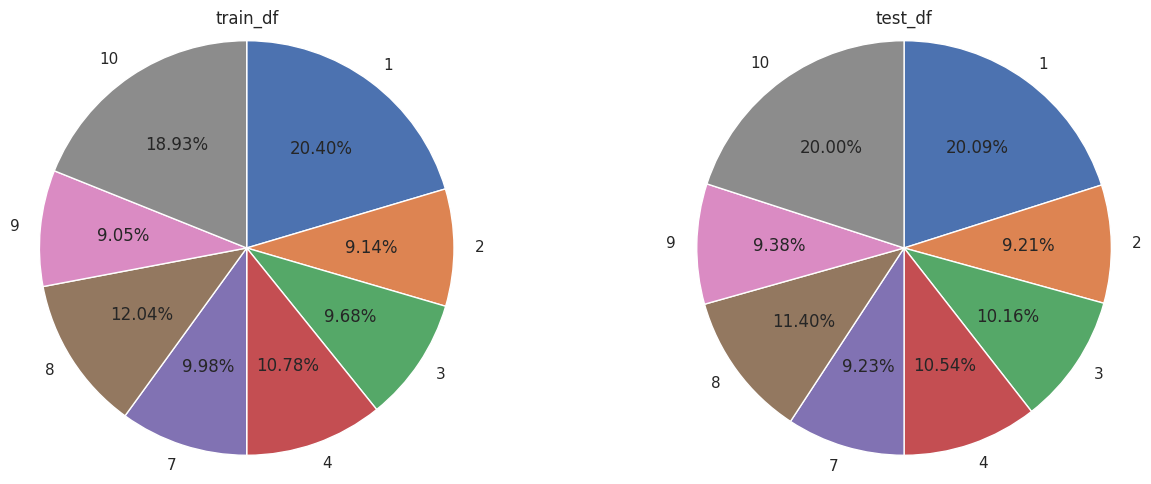

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))


counts = train_df["rating"].value_counts()


labels = sorted(counts.keys())



axs[0].pie([counts[i] for i in labels],
           labels=labels,
           autopct="%.2f%%",
           radius=1.2,
           counterclock=False,
           startangle=90)

axs[0].set_title("train_df")



counts = test_df["rating"].value_counts()

axs[1].pie([counts[i] for i in labels],
           labels=labels,
           autopct="%.2f%%",
           radius=1.2,
           counterclock=False,
           startangle=90)

axs[1].set_title("test_df")



plt.tight_layout()
plt.show()

Number of samples per each rating label is slightly different. The most popular rating is either 1 or 10, while more moderate reviews have less samples per each label. Distribution of samples per each label is almost the same in train and test data

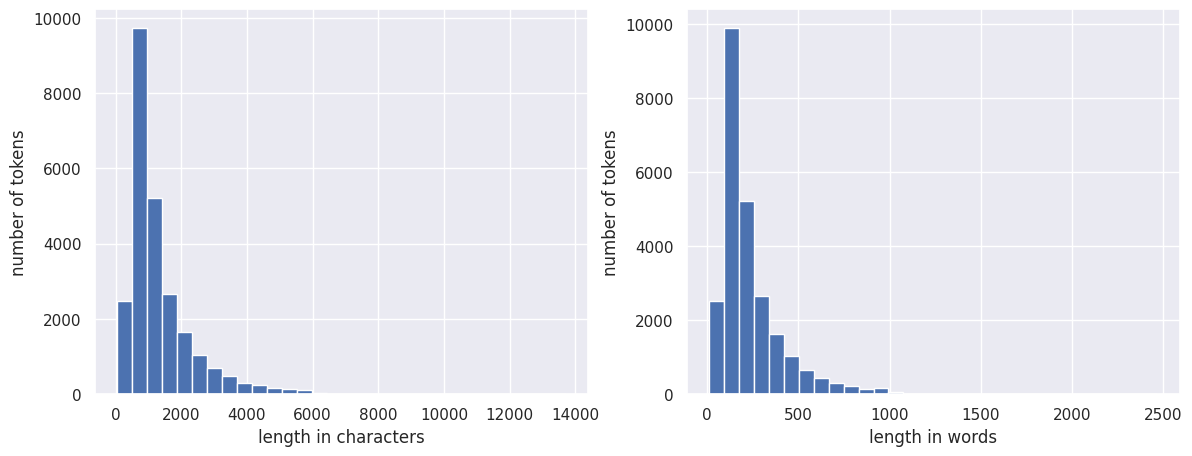

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].hist(train_df["text"].map(len), bins=30)
axs[0].set_xlabel("length in characters")
axs[0].set_ylabel("number of tokens")

axs[1].hist(train_df["text"].map(lambda x: len(x.split())), bins=30)
axs[1].set_xlabel("length in words")
axs[1].set_ylabel("number of tokens")


plt.show()

In [ ]:
train_df["text"].map(lambda x: len(x.split())).describe()

count    25000.000000
mean       233.787200
std        173.733032
min         10.000000
25%        127.000000
50%        174.000000
75%        284.000000
max       2470.000000
Name: text, dtype: float64

In [ ]:
test_df["text"].map(lambda x: len(x.split())).describe()

count    25000.000000
mean       228.526680
std        168.883693
min          4.000000
25%        126.000000
50%        172.000000
75%        277.000000
max       2278.000000
Name: text, dtype: float64

The majority of reviews have the length around 200 words, while some of them are longer then 2000 words, all reviews in the training data contain at least 10 words, but there is a review from test data with only 4 words. The length in characters corresponds to the length in words

# Classical ML

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

## Countvectorizer + LogReg

### Rating

In [ ]:
vectorizer = CountVectorizer().fit(train_df["text"])

train_encoded = vectorizer.transform(train_df["text"])
test_encoded =  vectorizer.transform(test_df["text"])

In [ ]:
log_reg = LogisticRegression().fit(train_encoded, train_df["rating"])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
y_pred = log_reg.predict(test_encoded)

accuracy_score(y_pred, test_df["rating"])

0.399

### Sentiment

In [ ]:
accuracy_score(np.where(y_pred < 5, 1, 0), np.array(test_df["sentiment"]))

0.85612

In [ ]:
log_reg = LogisticRegression().fit(train_encoded, train_df["sentiment"])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
y_pred = log_reg.predict(test_encoded)

accuracy_score(y_pred, test_df["sentiment"])

0.86336

Training separate binary classifier for sentiment analysis increases accuracy

## TfidfVectorizer + LogReg

### Rating

In [ ]:
tf_idf = TfidfVectorizer().fit(train_df["text"])

train_encoded = tf_idf.transform(train_df["text"])
test_encoded =  tf_idf.transform(test_df["text"])

In [ ]:
log_reg = LogisticRegression().fit(train_encoded, train_df["rating"])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
y_pred = log_reg.predict(test_encoded)

accuracy_score(y_pred, test_df["rating"])

0.428

### Sentiment

In [ ]:
accuracy_score(np.where(y_pred < 5, 1, 0), np.array(test_df["sentiment"]))

0.87356

In [ ]:
log_reg = LogisticRegression().fit(train_encoded, train_df["sentiment"])

In [ ]:
y_pred = log_reg.predict(test_encoded)

accuracy_score(y_pred, test_df["sentiment"])

0.88316

## Hyperparameters tuning

### TfidfVectorizer + LogReg

In [ ]:
params = [{
           "tfidf_vec__lowercase": [True, False],
           "tfidf_vec__ngram_range" : [(1, 1), (1, 2)],
           "tfidf_vec__stop_words": ["english", None],
           "tfidf_vec__min_df": [0, 0.0001, 0.0005, 0.001, 0.01],
           "logreg__C": [0.1, 0.5, 1.0],
           "tfidf_vec__token_pattern": [r"(?u)\b\w\w+\b", r"\S+", r"[^\w\s]+|\b\w+\b"]
           }]

#### Rating

In [ ]:
rating_predictor = Pipeline([
    ("tfidf_vec", TfidfVectorizer()),
    ("logreg", LogisticRegression()),
])

In [ ]:
rating_predictor_rs = RandomizedSearchCV(rating_predictor,
                                         params,
                                         scoring="accuracy",
                                         n_jobs=-1,
                                         refit=True,
                                         random_state=SEED,
                                         n_iter=30)

In [ ]:
rating_predictor_rs.fit(train_df.text, train_df.rating)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomizedSearchCV(estimator=Pipeline(steps=[('tfidf_vec', TfidfVectorizer()),
                                             ('logreg', LogisticRegression())]),
                   n_iter=30, n_jobs=-1,
                   param_distributions=[{'logreg__C': [0.1, 0.5, 1.0],
                                         'tfidf_vec__lowercase': [True, False],
                                         'tfidf_vec__min_df': [0, 0.0001,
                                                               0.0005, 0.001,
                                                               0.01],
                                         'tfidf_vec__ngram_range': [(1, 1),
                                                                    (1, 2)],
                                         'tfidf_vec__stop_words': ['english',
                                                                   None],
                                         'tfidf_vec__token_pattern': ['(?u)\\b\\w\\w+\\b',
                                                                      '\\S+',
                                                                      '[^\\w\\s]+|\\b\\w+\\b']}],
                   random_state=42, scoring='accuracy')

In [ ]:
rating_predictor_rs.best_score_

0.4566800000000001

In [ ]:
accuracy_score(test_df.rating,
               rating_predictor_rs.predict(test_df.text))

0.45636

In [ ]:
rating_predictor_rs.best_params_

{'tfidf_vec__token_pattern': '[^\\w\\s]+|\\b\\w+\\b',
 'tfidf_vec__stop_words': 'english',
 'tfidf_vec__ngram_range': (1, 2),
 'tfidf_vec__min_df': 0.0005,
 'tfidf_vec__lowercase': True,
 'logreg__C': 1.0}

#### Sentiment

In [ ]:
binary_classifier = Pipeline([
    ("tfidf_vec", TfidfVectorizer()),
    ("logreg", LogisticRegression()),
])

In [ ]:
params = [{
           "tfidf_vec__lowercase": [True, False],
           "tfidf_vec__ngram_range" : [(1, 1), (1, 2)],
           "tfidf_vec__stop_words": ["english", None],
           "tfidf_vec__min_df": [0, 0.0001, 0.0005, 0.001, 0.01],
           "logreg__C": [0.1, 0.5, 1.0],
           "tfidf_vec__token_pattern": [r"(?u)\b\w\w+\b", r"\S+", r"[^\w\s]+|\b\w+\b"]
           }]

In [ ]:
binary_classifier_rs = RandomizedSearchCV(binary_classifier,
                                          params,
                                          scoring="accuracy",
                                          n_jobs=-1,
                                          refit=True,
                                          random_state=SEED,
                                          n_iter=30)

In [ ]:
binary_classifier_rs.fit(train_df.text, train_df.sentiment)

RandomizedSearchCV(estimator=Pipeline(steps=[('tfidf_vec', TfidfVectorizer()),
                                             ('logreg', LogisticRegression())]),
                   n_iter=30, n_jobs=-1,
                   param_distributions=[{'logreg__C': [0.1, 0.5, 1.0],
                                         'tfidf_vec__lowercase': [True, False],
                                         'tfidf_vec__min_df': [0, 0.0001,
                                                               0.0005, 0.001,
                                                               0.01],
                                         'tfidf_vec__ngram_range': [(1, 1),
                                                                    (1, 2)],
                                         'tfidf_vec__stop_words': ['english',
                                                                   None],
                                         'tfidf_vec__token_pattern': ['(?u)\\b\\w\\w+\\b',
                                                                      '\\S+',
                                                                      '[^\\w\\s]+|\\b\\w+\\b']}],
                   random_state=42, scoring='accuracy')

In [ ]:
binary_classifier_rs.best_score_

0.8942

In [ ]:
accuracy_score(test_df.sentiment,
               binary_classifier_rs.predict(test_df.text))

0.89496

In [ ]:
binary_classifier_rs.best_params_

{'tfidf_vec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf_vec__stop_words': None,
 'tfidf_vec__ngram_range': (1, 2),
 'tfidf_vec__min_df': 0.001,
 'tfidf_vec__lowercase': True,
 'logreg__C': 1.0}

### HashVectorizer + LogReg

In [11]:
params = [{
           "hash_vec__lowercase": [True, False],
           "hash_vec__ngram_range" : [(1, 1), (1, 2)],
           "hash_vec__stop_words": ["english", None],
           "hash_vec__token_pattern": [r"(?u)\b\w\w+\b", r"\S+", r"[^\w\s]+|\b\w+\b"],
           "logreg__C": [0.1, 0.5, 1.0]
           }]

#### Rating

In [ ]:
rating_predictor = Pipeline([
    ("hash_vec", HashingVectorizer()),
    ("logreg", LogisticRegression()),
])

In [ ]:
rating_predictor_rs = RandomizedSearchCV(rating_predictor,
                                         params,
                                         scoring="accuracy",
                                         n_jobs=-1,
                                         refit=True,
                                         random_state=SEED,
                                         n_iter=20)

In [ ]:
rating_predictor_rs.fit(train_df.text, train_df.rating)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomizedSearchCV(estimator=Pipeline(steps=[('hash_vec', HashingVectorizer()),
                                             ('logreg', LogisticRegression())]),
                   n_iter=20, n_jobs=-1,
                   param_distributions=[{'hash_vec__lowercase': [True, False],
                                         'hash_vec__ngram_range': [(1, 1),
                                                                   (1, 2)],
                                         'hash_vec__stop_words': ['english',
                                                                  None],
                                         'hash_vec__token_pattern': ['(?u)\\b\\w\\w+\\b',
                                                                     '\\S+',
                                                                     '[^\\w\\s]+|\\b\\w+\\b'],
                                         'logreg__C': [0.1, 0.5, 1.0]}],
                   random_state=42, scoring='accuracy')

In [ ]:
rating_predictor_rs.best_params_

{'logreg__C': 1.0,
 'hash_vec__token_pattern': '[^\\w\\s]+|\\b\\w+\\b',
 'hash_vec__stop_words': 'english',
 'hash_vec__ngram_range': (1, 2),
 'hash_vec__lowercase': False}

In [ ]:
rating_predictor_rs.best_score_

0.4236

In [ ]:
accuracy_score(test_df.rating,
               rating_predictor_rs.predict(test_df.text))

0.43096

#### Sentiment

In [12]:
binary_classifier = Pipeline([
    ("hash_vec", HashingVectorizer()),
    ("logreg", LogisticRegression()),
])

In [ ]:
binary_classifier_rs = RandomizedSearchCV(binary_classifier,
                                          params,
                                          scoring="accuracy",
                                          n_jobs=-1,
                                          refit=True,
                                          random_state=SEED,
                                          n_iter=30)

In [ ]:
binary_classifier_rs.fit(train_df.text, train_df.sentiment)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomizedSearchCV(estimator=Pipeline(steps=[('hash_vec', HashingVectorizer()),
                                             ('logreg', LogisticRegression())]),
                   n_iter=30, n_jobs=-1,
                   param_distributions=[{'hash_vec__lowercase': [True, False],
                                         'hash_vec__ngram_range': [(1, 1),
                                                                   (1, 2)],
                                         'hash_vec__stop_words': ['english',
                                                                  None],
                                         'hash_vec__token_pattern': ['(?u)\\b\\w\\w+\\b',
                                                                     '\\S+',
                                                                     '[^\\w\\s]+|\\b\\w+\\b'],
                                         'logreg__C': [0.1, 0.5, 1.0]}],
                   random_state=42, scoring='accuracy')

In [ ]:
binary_classifier_rs.best_params_

{'logreg__C': 1.0,
 'hash_vec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'hash_vec__stop_words': 'english',
 'hash_vec__ngram_range': (1, 2),
 'hash_vec__lowercase': False}

In [ ]:
binary_classifier_rs.best_score_

0.8678799999999999

In [ ]:
accuracy_score(test_df.sentiment,
               binary_classifier_rs.predict(test_df.text))

0.86836

# Fasttext embeddings

In [ ]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4393181 sha256=bf5e86d9a15f5b511b1efaf8b4dee49dc1c639bb22f5956ebf25d71ea1301c7e
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [ ]:
import fasttext
from fasttext.FastText import load_model

Prepare data in the format reqired by fasttext classifier

In [ ]:
train_train_df, train_eval_df = train_test_split(train_df, random_state=SEED)

Data for hyperparameters tuning

In [ ]:
fast_train = pd.DataFrame({"text": np.array(train_train_df.text.str.replace("\n", " ")),
                           "rating": np.array(train_train_df.rating.map(lambda x: f"__rating__{x}")),
                           "sentiment": np.array(train_train_df.sentiment.map(lambda x: f"__sentiment__{x}"))
                           })


fast_eval = pd.DataFrame({
                         "text": np.array(train_eval_df.text.str.replace("\n", " ")),
                         "rating": np.array(train_eval_df.rating.map(lambda x: f"__rating__{x}")),
                         "sentiment": np.array(train_eval_df.sentiment.map(lambda x: f"__sentiment__{x}"))
                         })

In [ ]:
fast_train.to_csv("train_data", index=False, header=False, sep=" ")
fast_eval.to_csv("eval_data", index=False, header=False, sep=" ")

## Rating

In [ ]:
fasttext_clf = fasttext.train_supervised(input="train_data",
                                         autotuneValidationFile="eval_data",
                                         autotuneDuration=600,
                                         label="__rating__")

In [ ]:
pred_labels = test_df["text"].map(lambda x: fasttext_clf.predict(x)[0][0])
y_pred = [int(re.findall("\d+", i)[0]) for i in pred_labels]
accuracy_score(y_pred, test_df["rating"])

0.34548

## Sentiment

In [ ]:
fasttext_clf = fasttext.train_supervised(input="train_data",
                                         autotuneValidationFile="eval_data",
                                         autotuneDuration=600,
                                         label="__sentiment__")

In [ ]:
pred_labels = test_df["text"].map(lambda x: fasttext_clf.predict(x)[0][0])
y_pred = [int(re.findall("\d+", i)[0]) for i in pred_labels]
accuracy_score(y_pred, test_df["sentiment"])

0.8532

# Preparation for deployment

## Train model on the whole dataset

I"ve chosen HashVectorizer + LogReg pipline for the deployment

### Rating

In [ ]:
rating_predictor.set_params(**rating_predictor_rs.best_params_)

Pipeline(steps=[('hash_vec',
                 HashingVectorizer(lowercase=False, ngram_range=(1, 2),
                                   stop_words='english',
                                   token_pattern='[^\\w\\s]+|\\b\\w+\\b')),
                ('logreg', LogisticRegression())])

In [ ]:
rating_predictor.fit(pd.concat([train_df, test_df]).text,
                     pd.concat([train_df, test_df]).rating)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('hash_vec',
                 HashingVectorizer(lowercase=False, ngram_range=(1, 2),
                                   stop_words='english',
                                   token_pattern='[^\\w\\s]+|\\b\\w+\\b')),
                ('logreg', LogisticRegression())])

### Sentiment

In [ ]:
binary_classifier.set_params(**binary_classifier_rs.best_params_)

Pipeline(steps=[('hash_vec',
                 HashingVectorizer(lowercase=False, ngram_range=(1, 2),
                                   stop_words='english')),
                ('logreg', LogisticRegression())])

In [ ]:
binary_classifier.fit(pd.concat([train_df, test_df]).text,
                      pd.concat([train_df, test_df]).sentiment)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('hash_vec',
                 HashingVectorizer(lowercase=False, ngram_range=(1, 2),
                                   stop_words='english')),
                ('logreg', LogisticRegression())])

## Model saving

In [21]:
import pickle

In [ ]:
with open("rating_predictor", "wb") as f:
  pickle.dump(rating_predictor, f)

In [22]:
with open("binary_classifier", "wb") as f:
  pickle.dump(binary_classifier, f)

# Going deeper

In [ ]:
!pip install evaluate==0.4.0 -q
!pip install transformers==4.28.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.4 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          DataCollatorWithPadding, TrainingArguments, Trainer)
import evaluate

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

## Dataset preparation

In [ ]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

In [ ]:
train_files = [*glob.glob("/content/aclImdb/train/neg/*.txt"), *glob.glob("/content/aclImdb/train/pos/*.txt")]
train_labels = [int(re.findall("\d+", i)[-1]) for i in train_files]

test_files = [*glob.glob("/content/aclImdb/test/neg/*.txt"), *glob.glob("/content/aclImdb/test/pos/*.txt")]
test_labels = [int(re.findall("\d+", i)[-1]) for i in test_files]

In [ ]:
id2label = dict(enumerate(set(train_labels)))
label2id = {v: k for k, v in id2label.items()}

In [ ]:
train_labels = [label2id[i] for i in train_labels]
test_labels = [label2id[i] for i in test_labels]

In [ ]:
data_files = {"train":  train_files,
              "test":  test_files}

dataset = load_dataset("text", data_files=data_files)

Resolving data files:   0%|          | 0/25000 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/25000 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset text downloaded and prepared to /root/.cache/huggingface/datasets/text/default-1663db52a8f72011/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text'],
        num_rows: 25000
    })
})

In [ ]:
dataset["train"] = dataset["train"].add_column("label", train_labels)
dataset["test"] = dataset["test"].add_column("label", test_labels)

In [ ]:
dataset["test"][0]

{'text': "We thought this was one of the worst movies ever. I had to volunteer to watch the end. The romance was not believable; the characters were not developed; the love affair made hardly any sense; it was miscast; and scenery was absolutely stupid because it was either (my opinion) like the ADAMS FAMILY GOES ON VACATION...just creepy, gypsy and cheesy; and the OUTERBANKS does not look typically like those houses on the surf; and who would spend the night in one during a hurricane if it was not theirs. Also..it was not realistic. hurrricanes give you plenty of notice to batten down the hatches.<br /><br />Also the friend was superfluous; and did not match the story What did the civil war have to do with the outerbanks anyway? I also have to mention the wardrobe...did D. Lane have to have a scarf/pashmina/shawl on in every scene? It was overdone. She looked good enough to not have to hide things; without making them obvious like with light slacks.<br /><br />Lastly I am concerned wi

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=512)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)
tokenized_dataset

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
})

## Model finetuning

In [ ]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    bin_pred = (predictions < 4).astype(int)
    bin_labels = (labels < 4).astype(int)

    return {"Rating_Accuracy": accuracy.compute(predictions=predictions, references=labels),
            "Sentiment_Accuracy": accuracy.compute(predictions=bin_pred, references=bin_labels)}

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "xlnet-base-cased",
    num_labels=len(set(train_labels)),
    id2label=id2label,
    label2id=label2id
)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [ ]:
batch_size = 2

training_args = TrainingArguments(
    output_dir="pa-shk/movie-review-classifier",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Cloning https://huggingface.co/pa-shk/movie-review-classifier into local empty directory.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Rating Accuracy,Sentiment Accuracy
1,1.358300,1.331332,{'accuracy': 0.49692},{'accuracy': 0.9428}
2,1.206500,1.382250,{'accuracy': 0.51684},{'accuracy': 0.94672}


Trainer is attempting to log a value of "{'accuracy': 0.49692}" of type <class 'dict'> for key "eval/Rating_Accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.9428}" of type <class 'dict'> for key "eval/Sentiment_Accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.51684}" of type <class 'dict'> for key "eval/Rating_Accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.94672}" of type <class 'dict'> for key "eval/Sentiment_Accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
